In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
sns.set_palette('rainbow')
sns.set_style('whitegrid')
import plotly.express as px

In [ ]:
# these 2 lines fix a sporatic loading error in plotly
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
sns.set_style('darkgrid')


In [ ]:

# pyspark
import pandas as pd
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col


from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

CSV_FILE= pd.read_csv('Final database.csv')
print(CSV_FILE)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (7,8,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types.Specify dtype option on import or set low_memory=False.



            Country                                                Uri  \
0            Global  https://open.spotify.com/track/6FyRXC8tJUh863J...   
1               USA  https://open.spotify.com/track/6FyRXC8tJUh863J...   
2         Argentina  https://open.spotify.com/track/6FyRXC8tJUh863J...   
3           Belgium  https://open.spotify.com/track/6FyRXC8tJUh863J...   
4       Switzerland  https://open.spotify.com/track/6FyRXC8tJUh863J...   
...             ...                                                ...   
170628       Taiwan  https://open.spotify.com/track/4v29A51TqtD2KFS...   
170629       Taiwan  https://open.spotify.com/track/7InvbALrXpsz58J...   
170630       Taiwan  https://open.spotify.com/track/5rCNIuDc3VD7q6H...   
170631       Taiwan  https://open.spotify.com/track/0525Cll5exsrybt...   
170632       Taiwan  https://open.spotify.com/track/6IUFuke9UsBg2FD...   

        Popularity       Title            Artist Album/Single  \
0         31833.95  adan y eva      Paulo Lond

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
spark = SparkSession.builder.master("local[2]").appName("Spotify-Huge-Dataset").getOrCreate() #.enableHiveSupport()
spark

In [ ]:
# Old way depreciated in 3.0.0
sc = spark.sparkContext
sqlContext = SQLContext(sc)
# sqlContext = SQLContext(spark)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [ ]:
df = spark.read.option("header", True).csv('Final database.csv')
df = df.withColumn("Release_date", F.to_date("Release_date", "yyyy-MM-dd"))
numerical_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics',
                      'instrumentalness', 'tempo', 'duration_ms', 
                      'time_signature', 'Days_since_release', 'n_words']

for c in numerical_features:
    df = df.withColumn(c, df[c].cast("float"))
    
cols_to_drop = ['syuzhet_norm', 'bing_norm', 'afinn_norm', 'nrc_norm', 'syuzhet', 'bing'] 
for c in cols_to_drop:
    df.drop(c).collect()
    
df.printSchema()
# df.show(n=1, truncate=False, vertical=True)

root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: string (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: date (nullable = true)
 |-- Track_number: string (nullable = true)
 |-- Tracks_in_album: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acoustics: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveliness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: float (nul

EDA

In [ ]:
# how many unique songs are there in the dataset?
df.select(["Title","Artist"]).distinct().count()

56241

In [ ]:
print("Dataset Shape using spark syntax:\n",(df.count(), len(df.columns)))

Dataset Shape using spark syntax:
 (170633, 151)


In [ ]:
# each count is a song that was in the top 200 most played on a day on spotify during the last 3 years
result_df = (df.groupBy("Artist")
               .count()
               .orderBy("count", ascending=False)
               .limit(10)
               .toPandas()
            )
px.bar(result_df, y='Artist', x='count', title='Most Prolific Artists')

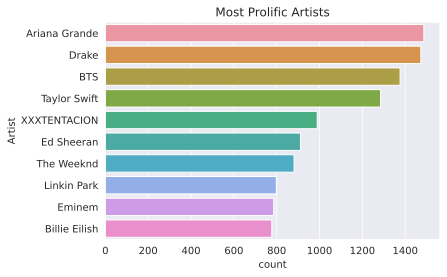

In [ ]:
# same as above but with seaborn (sometimes plotly doesn't show up in the published notebok)
sns.barplot(data=result_df, y='Artist', x='count').set_title('Most Prolific Artists');

In [ ]:
df.createOrReplaceTempView("df_table")

In [ ]:
print("Now using the SQL Context. We can check it's the same length as before")
query = """
    SELECT Count(*) as Dataset_Length
    FROM df_table
"""
res = spark.sql(query).show()

Now using the SQL Context. We can check it's the same length as before
+--------------+
|Dataset_Length|
+--------------+
|        170633|
+--------------+



In [ ]:
# Most popular artist (by sum of popularity of songs) in the USA
query = """
SELECT
                                    Artist, 
       ROUND(SUM(Popularity), 2) AS Populartiy
FROM df_table
WHERE USA == 1
GROUP BY Artist
ORDER BY AVG(Popularity) DESC
LIMIT 10
"""

res = spark.sql(query)
res.show(10, truncate=False)

+------------------------------+----------+
|Artist                        |Populartiy|
+------------------------------+----------+
|Post Malone - Quavo           |130719.15 |
|XXXTENTACION - Trippie Redd   |97016.35  |
|Meek Mill - Drake             |83235.95  |
|Post Malone - 21 Savage       |159633.25 |
|Billie Eilish - Khalid        |79693.9   |
|Marshmello - Bastille         |74560.5   |
|Cardi B - Bad Bunny - J Balvin|74381.6   |
|Migos - Lil Uzi Vert          |70138.2   |
|BlocBoy JB - Drake            |69576.75  |
|Kendrick Lamar - Zacari       |67838.15  |
+------------------------------+----------+



In [ ]:
# select only the songs released in 1939
(df.filter(F.year(df['Release_date']) == 1939)
   .select('Title', 'Artist','Release_date', 'Genre')
   .distinct()
   .show(5, truncate=False)
)

+--------------------------------------------+------------+------------+---------------+
|Title                                       |Artist      |Release_date|Genre          |
+--------------------------------------------+------------+------------+---------------+
|moonlight serenade - 2005 remastered version|Glenn Miller|1939-09-01  |adult standards|
+--------------------------------------------+------------+------------+---------------+



In [ ]:
query = """
SELECT
        ROUND(Year(Release_date), -1) AS Decade,
        Round(Popularity, 2)          AS Popularity,
                                         Title,
                                         Artist
FROM df_table
INNER JOIN (SELECT Max(Popularity) as mp
            FROM df_table
            WHERE ROUND(Year(Release_date), -1) IS NOT NULL
            AND USA == 1
            GROUP BY ROUND(Year(Release_date), -1)
           ) AS temp
ON temp.mp = df_table.Popularity
ORDER BY Decade ASC, Popularity ASC
"""

res = spark.sql(query)
res.toPandas().drop_duplicates(subset='Decade', keep="last")

,Decade,Popularity,Title,Artist
10,NaN,98.60,say it loud - im black and im proud,James Brown
11,1940.0,840.50,have yourself a merry little christmas,Judy Garland
12,1950.0,997.60,mele kalikimaka,Bing Crosby - The Andrews Sisters
15,1960.0,9704.95,blue christmas,Elvis Presley
16,1970.0,98.40,me and julio down by the schoolyard,Paul Simon
24,1980.0,98.60,listen to her heart,Tom Petty and the Heartbreakers
32,1990.0,98.40,home for the holidays - 1959 version,Perry Como
40,2000.0,9476.05,feliz navidad,José Feliciano
75,2010.0,98.60,suomirokkia,Aknestik
383,2020.0,99912.30,drip too hard,Lil Baby - Gunna


In [ ]:
# highly optimized version of the above query via scalar-aggregate-reduction
query = """
SELECT
    ROUND(Year(Release_date), -1) as Decade,
    ROUND(Max(Popularity), 2) as Popularity,
    SUBSTRING(MAX(CONCAT(LPAD(Popularity, 11, 0), Title)), 12) AS Title,
    SUBSTRING(MAX(CONCAT(LPAD(Popularity, 11, 0), Artist)), 12) AS Artist
FROM
    df_table
WHERE
    ROUND(Year(Release_date), -1) IS NOT NULL
    AND USA == 1
GROUP BY Decade
ORDER BY Decade ASC
"""

spark.sql(query).show()

+------+----------+--------------------+--------------------+
|Decade|Popularity|               Title|              Artist|
+------+----------+--------------------+--------------------+
|  1940|     840.5|     white christmas|Bing Crosby - Ken...|
|  1950|     997.6|ill be home for c...|         Bing Crosby|
|  1960|   9704.95|    jingle bell rock|         Bobby Helms|
|  1970|      98.4|what christmas me...|       Stevie Wonder|
|  1980|      98.6|dreams - 2004 rem...|       Fleetwood Mac|
|  1990|     97.75|            spoonman|         Soundgarden|
|  2000|   9476.05|       feliz navidad|      José Feliciano|
|  2010|     97.75|         tongue tied|           Grouplove|
|  2020|   99912.3|       drip too hard|    Lil Baby - Gunna|
+------+----------+--------------------+--------------------+



Most popular Genre per decade

In [ ]:
 # Most popular genres, period.
query = """
SELECT Genre, COUNT(*) AS Tally
FROM df_table
GROUP BY Genre
ORDER BY Tally DESC
"""
spark.sql(query).show(5)

+---------+-----+
|    Genre|Tally|
+---------+-----+
|dance pop|25351|
|    latin| 7591|
|      pop| 7146|
|    k-pop| 4053|
|      n-a| 3952|
+---------+-----+
only showing top 5 rows



In [ ]:
query = """
SELECT
      ROUND(Year(Release_date), -1) AS Decade,
      Genre, COUNT(Genre)           AS counts
FROM  df_table
WHERE ROUND(Year(Release_date), -1) IS NOT NULL
GROUP BY Decade, Genre
ORDER BY COUNT(Genre) DESC
"""

res = (spark.sql(query)
            .dropDuplicates(subset=['Decade'])
            .orderBy('Decade')
            .show()
      )
# res.toPandas().drop_duplicates(subset='Decade', keep="first")

+------+-------------------+------+
|Decade|              Genre|counts|
+------+-------------------+------+
|  1900|vocal harmony group|     1|
|  1930|        movie tunes|     1|
|  1940|    adult standards|    39|
|  1950|    adult standards|    36|
|  1960|    adult standards|   186|
|  1970|       classic soul|   152|
|  1980|         album rock|   379|
|  1990|         irish rock|   170|
|  2000|  alternative metal|   477|
|  2010|          dance pop|  1052|
|  2020|          dance pop| 23496|
+------+-------------------+------+



For each track, what day was it most popular?

In [ ]:
query = """
SELECT Title, Artist, Release_date, MAX(Popularity)
FROM df_table
WHERE Artist == "Paulo Londra"
GROUP BY Title, Artist, Release_date
LIMIT 10
"""

res = spark.sql(query).show()

+--------------------+------------+------------+------------------+
|               Title|      Artist|Release_date|   max(Popularity)|
+--------------------+------------+------------+------------------+
|          adan y eva|Paulo Londra|  2018-11-05| 849.6000000000001|
|          adan y eva|Paulo Londra|  2019-05-23| 57194.60000000001|
|    chica paranormal|Paulo Londra|  2018-07-24|           6341.35|
|    chica paranormal|Paulo Londra|  2019-05-23|           9409.05|
|condenado para el...|Paulo Londra|  2017-12-04| 617.6000000000001|
|condenado para el...|Paulo Londra|  2018-11-03|             852.0|
|condenado para el...|Paulo Londra|  2019-05-23| 586.7500000000001|
|confiado & tranquilo|Paulo Londra|  2017-05-30|375.20000000000016|
|        cámara lenta|Paulo Londra|  2017-10-07| 8088.800000000004|
|      demasiado loco|Paulo Londra|  2019-05-23| 6337.350000000001|
+--------------------+------------+------------+------------------+



Let's see how music changed over the decade

In [ ]:
sound_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics']
col_names = ['Decade']
col_names.extend(sound_features)

df_music_features = (df.sample(.2, seed=42)
                       .groupBy(F.round(F.year(df.Release_date), -1))
                       .agg({feature: 'mean' for feature in sound_features})
                       .toDF(*col_names)
                       .orderBy('Decade')
                       .toPandas()
                       .dropna(axis=0)
                    )
fig = px.line(df_music_features, x='Decade', y=sound_features, title='Song Characteristics Over the Decades')
fig.show()

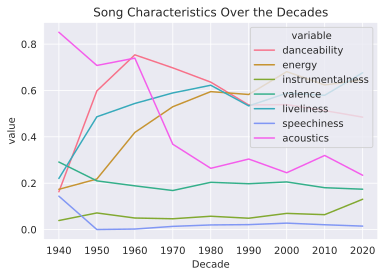

In [ ]:
# same as above but with seaborn. (sometimes plotly doesn't show up in the published notebok)
sns.lineplot(data=pd.melt(df_music_features, ['Decade']), x='Decade', y='value', hue='variable').set_title('Song Characteristics Over the Decades');

**CLUSTERING**

First check out the cosine similiarty of song feature vectors

In [ ]:
###### First KPop ######
query_kpop = """
SELECT Title, Artist, {}
FROM df_table
WHERE `k-pop` = 1
""".format(', '.join(numerical_features))

df_kpop_songs = (spark.sql(query_kpop)
                      .sample(.1) # returns a list with a randomly selection of a specified number of items from a sequnce
                      .dropna()
                      .toPandas() 
                )
####### Now Rap #######
query_rap = """
SELECT Title, Artist, {}
FROM df_table
WHERE rap = 1
""".format(', '.join(numerical_features))

df_rap_songs = (spark.sql(query_rap)
                     .sample(.1)
                     .dropna()
                     .toPandas() 
               )
df_rap_songs.head()

,Title,Artist,danceability,energy,instrumentalness,valence,liveliness,speechiness,acoustics,instrumentalness,tempo,duration_ms,time_signature,Days_since_release,n_words
0,betrayed,Lil Xan,0.821,0.434,0.000000,0.241,0.1280,0.1180,0.434,0.000000,120.012001,187173.0,4.0,953.0,346.0
1,betrayed,Lil Xan,0.821,0.434,0.000000,0.241,0.1280,0.1180,0.434,0.000000,120.012001,187173.0,4.0,953.0,346.0
2,do you remember,Chance the Rapper - Death Cab for Cutie,0.606,0.655,0.000000,0.696,0.1030,0.4020,0.139,0.000000,159.824005,236686.0,4.0,477.0,221.0
3,u deserve it,Trippie Redd - Chris King - Quan'ta,0.817,0.509,0.000004,0.551,0.0758,0.0316,0.547,0.000004,110.014000,244601.0,4.0,358.0,166.0
4,ball for me,Post Malone - Nicki Minaj,0.797,0.550,0.000000,0.543,0.0786,0.2400,0.513,0.000000,134.205994,206267.0,4.0,932.0,422.0


In [ ]:
df_kpop_songs.head()

,Title,Artist,danceability,energy,instrumentalness,valence,liveliness,speechiness,acoustics,instrumentalness,tempo,duration_ms,time_signature,Days_since_release,n_words
0,outnumbered,Dermot Kennedy,0.614,0.684,0.0,0.258,0.0976,0.1570,0.24700,0.0,156.850006,245700.0,4.0,520.0,241.0
1,bad boy,Red Velvet,0.714,0.736,0.0,0.814,0.0553,0.0457,0.19100,0.0,149.985001,210818.0,4.0,1020.0,417.0
2,more,K/DA - Madison Beer - (G)I-DLE - Lexie Liu - J...,0.660,0.787,0.0,0.199,0.3230,0.0320,0.00257,0.0,142.018005,217088.0,4.0,17.0,1344.0
3,more,K/DA - Madison Beer - (G)I-DLE - Lexie Liu - J...,0.660,0.787,0.0,0.199,0.3230,0.0320,0.00257,0.0,142.018005,217088.0,4.0,17.0,1344.0
4,shotgun,George Ezra,0.672,0.735,0.0,0.754,0.2420,0.0457,0.28600,0.0,115.740997,201287.0,4.0,967.0,215.0


In [ ]:
# it might be better to used a normalized cosine similarity instead of scaling first and then doing it.
from scipy import spatial
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() #Transform features by scaling each feature to a given range
transformer = Normalizer() #Each sample with at least one non zero component

scaled_kpop_df = scaler.fit_transform(df_kpop_songs.iloc[:, 2:]) # drop the title and artist with the iloc(select specific row in data set)
scaled_rap_df = scaler.fit_transform(df_rap_songs.iloc[:, 2:])


# cos similarity of a rap and a k-pop song
song1 = np.array(scaled_rap_df[1])
song2 = np.array(scaled_kpop_df[2])
result = 1 - spatial.distance.cosine(song1, song2)
print("Cosine similarity of a rap and a k-pop song:", result) #how similar irrespective of size 

Cosine similarity of a rap and a k-pop song: 0.8490080833435059


In [ ]:
# cos similarity of two rap songs
song1 = np.array(scaled_rap_df[1])
song2 = np.array(scaled_rap_df[10])
result = 1 - spatial.distance.cosine(song1, song2) #1d arrays
print("Cosine similarity of two rap songs:", result)

Cosine similarity of two rap songs: 0.9063965678215027


**DIMENSIONALITY** **REDUCTION**

In [ ]:
# let's add an OHE genre encoding
df_rap_songs = df_rap_songs.assign(is_rap=1,
                                   is_kpop=0
                                   )
df_kpop_songs = df_kpop_songs.assign(is_rap=0,
                                     is_kpop=1
                                     )
df_rap_and_kpop = pd.concat([df_rap_songs, df_kpop_songs])
X = scaler.fit_transform(df_rap_and_kpop.iloc[:, 2:])

pca = PCA(n_components=10) #stablizes the component
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.47312189 0.12979324 0.09884464 0.07443889 0.05210026 0.04172847
 0.03648898 0.02833869 0.0214485  0.02025342]


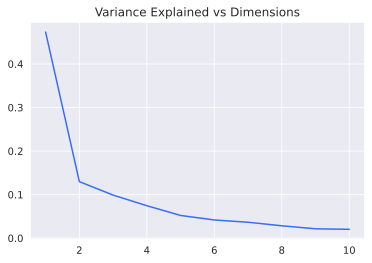

In [ ]:
sns.lineplot(x=[x for x in range(1, 11)], y=pca.explained_variance_ratio_).set_title("Variance Explained vs Dimensions");

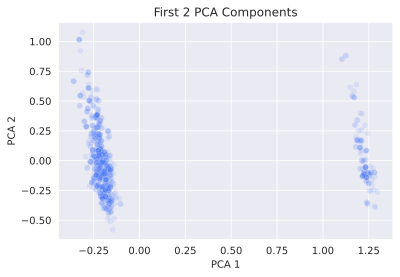

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
PCA_components = pd.DataFrame(principalComponents)

# sns.scatterplot(data=principalComponents, alpha=.1)
sns.scatterplot(x=PCA_components[0], y=PCA_components[1], alpha=.1).set_title("First 2 PCA Components");
plt.xlabel('PCA 1');
plt.ylabel('PCA 2');

**K MEANS CLUSTERING**

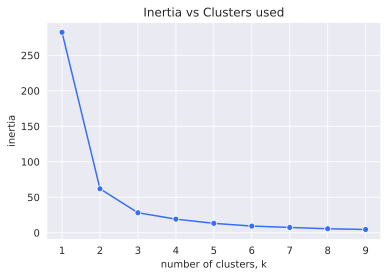

In [ ]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:2])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_) #measures how well a dataset was clustered by K-Means
    
sns.lineplot(x=ks, y=inertias, marker='o').set_title("Inertia vs Clusters used")
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

In [ ]:
df_pca_kmeans_plot = pd.concat([PCA_components, pd.Series(y_km)], axis=1)
df_pca_kmeans_plot.columns = ['PCA_1', 'PCA_2', 'Cluster']

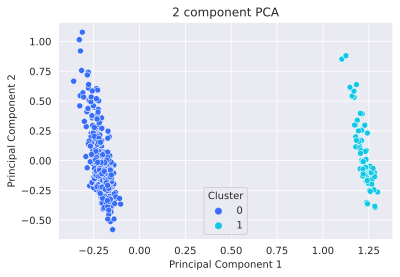

In [ ]:
sns.scatterplot(data=df_pca_kmeans_plot, x='PCA_1', y='PCA_2', hue='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA');

Find the most similar song

In [ ]:
query_all = """
SELECT Title, Artist, Genre, {}
FROM df_table
""".format(', '.join(numerical_features))

df_all_songs = (spark.sql(query_all)
                     .dropna() #removes the rows that contains NULL values
                     .toPandas()
                     .drop_duplicates(['Title', 'Artist'])
                     .reset_index(drop=True)
                )

In [ ]:
df_all_songs.columns

Index(['Title', 'Artist', 'Genre', 'danceability', 'energy',
       'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics',
       'instrumentalness', 'tempo', 'duration_ms', 'time_signature',
       'Days_since_release', 'n_words'],
      dtype='object')

In [ ]:
df_all_songs_ohe = pd.get_dummies(df_all_songs.drop(columns='Title'))
scaled_df_all_songs_ohe = scaler.fit_transform(df_all_songs_ohe)

In [ ]:
def get_most_similar_song(title, artist):
    title = title.lower()
    # get the vector for the requested song
    song_idx = df_all_songs.query(f"Title == '{title}' and Artist == '{artist}'").index.values[0]
    song_vector = scaled_df_all_songs_ohe[song_idx]
    
    # find the most similar song
    min_difference = 1
    closest_song_idx = 0
    for index, song in enumerate(scaled_df_all_songs_ohe):
        distance = spatial.distance.cosine(song_vector, song)
        if distance < min_difference:
            if index == song_idx:
                pass
            else:
                min_difference = distance
                closest_song_idx = index #np_iterator.index
    # get the title and the artist of the most similar song
    closest_song = df_all_songs.loc[closest_song_idx,['Title', 'Artist']]
    print("Closest Song:\n-------------", closest_song, sep="\n")
    return closest_song_idx

In [ ]:
get_most_similar_song("Numb", "Linkin Park")

Closest Song:
-------------
Title        crawling
Artist    Linkin Park
Name: 1470, dtype: object


1470

In [ ]:
spark.sql("SELECT Artist, Title FROM df_table WHERE Artist LIKE 'Radio%'").distinct().show(50)

+---------+------------------+
|   Artist|             Title|
+---------+------------------+
|Radiohead|             creep|
|Radiohead|      karma police|
|Radiohead|        man of war|
|Radiohead|          ill wind|
|Radiohead|      high and dry|
|Radiohead|      no surprises|
|Radiohead|  paranoid android|
|Radiohead|fake plastic trees|
+---------+------------------+



In [ ]:
get_most_similar_song("creep", "Radiohead")

Closest Song:
-------------
Title           californication
Artist    Red Hot Chili Peppers
Name: 5955, dtype: object


5955